In [1]:
import sqlite3
import h5py
import time
from PIL import Image
import requests
import imageio
from io import BytesIO
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf
import datetime, os
%matplotlib inline

In [2]:
# Required images are saved as an hdf5 file and uploaded to Kaggle as a Dataset.  
# Below saves images from the dataset to a numpy array.
hf = h5py.File("../input/images/images.hdf5", "r")
images = np.array(hf["/images"]).astype("uint8")
hf.close()

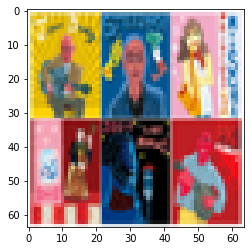

In [3]:
imshow(images[13])

In [4]:
# I have manually inspected all of the images and saved the indexes I wanted to remove in a file.
# This code block imports those indexes and remove them from the images array.
file1 = open('../input/removeindexes/1removeIndexes.txt', 'r')
indexes = file1.readlines()
indexes = list(map(int, indexes))
print(f'Number of images before removal: {len(images)}')
images = np.delete(images, indexes, axis = 0)
print(f'Number of images after removal: {len(images)}')

Number of images before removal: 65268
Number of images after removal: 51371


In [5]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D, Flatten, Dropout, AveragePooling2D, UpSampling2D, Input, Lambda, GaussianNoise
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.initializers import RandomNormal
from tensorboard.plugins.hparams import api as hp
from keras import backend
from keras.constraints import Constraint
from keras.callbacks import ModelCheckpoint
%load_ext tensorboard

In [6]:
def scale_images(images):
	# convert from unit8 to float32
	images = images.astype('float32')
	# scale from [0,255] to [-1,1]
	images = (images - 127.5) / 127.5
	return images

images = scale_images(images)

In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [8]:
# Definining the generator model. Commented out codelines are alternative layers that could be used.
def image_generator():

    generator = Sequential()

    generator.add(Dense(256*4*4, input_shape = (100,)))
    #generator.add(Dense(512*4*4, input_shape = (100,)))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Reshape((4,4,256)))
    #generator.add(Reshape((8,8,512)))

    init = RandomNormal(mean=0.0, stddev=0.02)

    generator.add(UpSampling2D())
    #generator.add(tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2)))
    #generator.add(Conv2DTranspose(128,kernel_size=2, strides=2, padding = "same", kernel_initializer=init))

    generator.add(Conv2D(128, kernel_size=4, padding = "same", kernel_initializer=init))
    generator.add(BatchNormalization())
    #generator.add(Dropout(0.2))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2D(128, kernel_size=4, padding = "same", kernel_initializer=init))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(UpSampling2D())
    #generator.add(tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2)))
    #generator.add(Conv2DTranspose(128,kernel_size=4, strides=2, padding = "same", kernel_initializer=init))

    generator.add(Conv2D(128, kernel_size=4, padding = "same", kernel_initializer=init))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))


    ##generator.add(Conv2DTranspose(128,kernel_size=4, strides=2, padding = "same", kernel_initializer=init))
    generator.add(UpSampling2D())
    #generator.add(tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2)))

    generator.add(Conv2D(128, kernel_size=4, padding = "same", kernel_initializer=init))
    generator.add(BatchNormalization())
    #generator.add(Dropout(0.2))
    generator.add(LeakyReLU(alpha=0.2))


    ##generator.add(Conv2DTranspose(128,kernel_size=4, strides=2, padding = "same", kernel_initializer=init))
    generator.add(UpSampling2D())
    #generator.add(tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2)))

    generator.add(Conv2D(128, kernel_size=4, padding = "same", kernel_initializer=init))
    #generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2D(3,kernel_size=4, padding = "same", activation='tanh', kernel_initializer=init))

    return generator

In [9]:

# For TPU Training
with strategy.scope():
    generator_model = image_generator()
    generator_model.summary()


"""
# For GPU Training
generator_model = image_generator()
generator_model.summary()
"""

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         5

'\n# For GPU Training\ngenerator_model = image_generator()\ngenerator_model.summary()\n'

In [10]:
def generate_input_data(n_samples):
  X = np.random.randn(100 * n_samples)
  X = X.reshape(n_samples, 100)
  return X

def create_fake_data(generator_model, n_samples):
  input = generate_input_data(n_samples)
  X = generator_model.predict(input)
  #y = np.zeros((n_samples, 1))
  y = np.ones((n_samples, 1))
  return X,y

'''
# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)
'''

'\n# implementation of wasserstein loss\ndef wasserstein_loss(y_true, y_pred):\n    return backend.mean(y_true * y_pred)\n'

In [11]:
# Definining the discriminator model. Commented out codelines are alternative layers that could be used.
def image_discriminator():
    # weight initialization
    init = RandomNormal(stddev=0.02)

    discriminator = Sequential()
    discriminator.add(Conv2D(128, kernel_size=4, padding = "same", input_shape = (64,64,3), kernel_initializer=init))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.4))
    

    discriminator.add(Conv2D(128, kernel_size=4,strides=(2,2), padding = "same", kernel_initializer=init))
    #discriminator.add(AveragePooling2D(pool_size=(2, 2)))
    #discriminator.add(BatchNormalization())
    #discriminator.add(GaussianNoise(0.2))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.4))
    

    discriminator.add(Conv2D(128, kernel_size=4,strides=(2,2), padding = "same", kernel_initializer=init))
    #discriminator.add(AveragePooling2D(pool_size=(2, 2)))
    #discriminator.add(BatchNormalization())
    #discriminator.add(GaussianNoise(0.2))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.4))


    discriminator.add(Conv2D(128, kernel_size=4,strides=(2,2), padding = "same", kernel_initializer=init))
    #discriminator.add(BatchNormalization())
    #discriminator.add(GaussianNoise(0.2))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.4))
    

    discriminator.add(Conv2D(128, kernel_size=4,strides=(2,2), padding = "same", kernel_initializer=init))
    #discriminator.add(BatchNormalization())
    #discriminator.add(GaussianNoise(0.2))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Flatten())
    #discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.add(Dense(1, activation='linear'))

    return discriminator

In [12]:

# For TPU Training
with strategy.scope():
    discriminator_model = image_discriminator()
    discriminator_model.summary()

# For GPU Training
"""
discriminator_model = image_discriminator()
discriminator_model.summary()
"""

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 128)       6272      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 128)      

'\ndiscriminator_model = image_discriminator()\ndiscriminator_model.summary()\n'

In [13]:
images.shape

(51371, 64, 64, 3)

In [14]:
import random
from numpy.random import choice

def load_real_data(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = -np.ones((n_samples, 1))
  return X,y

def load_fake_data(n_samples):
  X = np.random.rand(64 * 64 * 3 * n_samples)
  X = -1 + X * 2
  X = X.reshape((n_samples, 64,64,3))
  y = np.ones((n_samples, 1))
  return X,y

In [15]:
# Resource: https://keras.io/examples/generative/wgan_gp/#create-the-wgangp-model
class WGAN(keras.Model):
    def __init__(
            self,
            discriminator,
            generator,
            latent_dim,
            discriminator_extra_steps=5,
            gp_weight=10.0,
        ):
            super(WGAN, self).__init__()
            self.discriminator = discriminator
            self.generator = generator
            self.latent_dim = latent_dim
            self.d_steps = discriminator_extra_steps
            self.gp_weight = gp_weight
    
    # For TPU Training
    
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, steps_per_execution):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.steps_per_execution = steps_per_execution
    
    # For GPU Training
    """
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
    """
    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        # For WGAN-GP
        #gp = tf.reduce_mean((norm - 1.0) ** 2)
        # For WGAN-LP
        gp = tf.reduce_mean((tf.maximum(0., norm - 1.0)) ** 2)
        return gp
        
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [17]:
# Every Xth epoch, generate and save 3 images. 
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):

        if (epoch + 1) % 20 == 0:
          random_latent_vectors = np.random.rand(self.num_img, 100).astype(np.float32)
          generated_images = self.model.generator(random_latent_vectors)

          generated_images = (generated_images + 1) / 2.0

          for i in range(self.num_img):
            plt.imshow(generated_images[i])
            plt.axis('off')
            name = str(epoch) + '_generated_image_' + str(i) + '.png'
            plt.savefig(name, bbox_inches='tight')
            plt.close()


In [19]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():

    lr_gen = 0.00005
    lr_disc = 0.0002
    beta1 = 0.5
    gp = 10
    dstep = 5

    # Instantiate the optimizer for both networks
    generator_optimizer = keras.optimizers.RMSprop(
        learning_rate=lr_gen
    )
    discriminator_optimizer = keras.optimizers.RMSprop(
        learning_rate=lr_disc
    )

    # Define the loss functions for the discriminator,
    # which should be (fake_loss - real_loss).
    # We will add the gradient penalty later to this loss function.
    # tf.nn.compute_average_loss is required when using TPU.
    # when using GPU, I used tf.reduce_mean instead. 
    """
    def discriminator_loss(real_img, fake_img):
        real_loss = tf.reduce_mean(real_img)
        fake_loss = tf.reduce_mean(fake_img)
        return fake_loss - real_loss
    """

    def discriminator_loss(real_img, fake_img):
        real_loss = tf.nn.compute_average_loss(real_img, global_batch_size=128*8)
        fake_loss = tf.nn.compute_average_loss(fake_img, global_batch_size=128*8)
        return fake_loss - real_loss
    
    """
    # Define the loss functions for the generator.
    def generator_loss(fake_img):
        return -tf.reduce_mean(fake_img)
    """
    
    def generator_loss(fake_img):
        return -tf.nn.compute_average_loss(fake_img, global_batch_size=128*8)
    

    # Set the number of epochs for trainining.
    epochs = 2000

    # Instantiate the customer `GANMonitor` Keras callback.
    cbk = GANMonitor(num_img=3, latent_dim=100)


    # Save the model after every epoch
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filepath = "./savedModels/" + str(now) + "_model/{epoch:02d}/"
    # If you want name to be static:
    #filepath = "./savedModels/xxx_model/{epoch:02d}/"
    savepoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=False, save_freq=840, options=save_locally)

    # Instantiate the WGAN model.
    wgan = WGAN(
        discriminator=discriminator_model,
        generator=generator_model,
        latent_dim=100,
        discriminator_extra_steps=dstep,
        gp_weight=gp
    )

    # Compile the WGAN model.
    wgan.compile(
        d_optimizer=discriminator_optimizer,
        g_optimizer=generator_optimizer,
        g_loss_fn=generator_loss,
        d_loss_fn=discriminator_loss,
        steps_per_execution=16
    )

    # Uncomment to load a model
    #load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    #wgan.load_weights(dest, options = load_locally)

# Start training the model.
print("starting training")
history = wgan.fit(images[:42000], batch_size=128*8, epochs=epochs, initial_epoch=0, callbacks=[cbk, savepoint])

entering scope
creating model
compiling
starting training
Epoch 1/800
42/42 [==============================] - 116s 1s/step - d_loss: -1.1012 - g_loss: 0.5927
Epoch 2/800
42/42 [==============================] - 30s 714ms/step - d_loss: -0.9869 - g_loss: -0.7568
Epoch 3/800
42/42 [==============================] - 30s 714ms/step - d_loss: -0.8853 - g_loss: -1.3166
Epoch 4/800
42/42 [==============================] - 30s 714ms/step - d_loss: -1.0613 - g_loss: 1.6281
Epoch 5/800
42/42 [==============================] - 30s 714ms/step - d_loss: -1.0303 - g_loss: 4.6299
Epoch 6/800
42/42 [==============================] - 30s 714ms/step - d_loss: -1.0539 - g_loss: 2.5765
Epoch 7/800
42/42 [==============================] - 30s 714ms/step - d_loss: -0.8581 - g_loss: 4.3635
Epoch 8/800
42/42 [==============================] - 30s 714ms/step - d_loss: -1.0931 - g_loss: 2.3707
Epoch 9/800
42/42 [==============================] - 30s 714ms/step - d_loss: -0.6714 - g_loss: -0.6955
Epoch 10/800
4